### Face Recognition for the Happy House

Here we will build a face recognition system. 

The Detail of Face recognition technology you can find in my blog:

https://medium.com/@BhashkarKunal/face-recognition-real-time-webcam-face-recognition-system-using-deep-learning-algorithm-and-98cf8254def7

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.
    
**In this assignment, you will:**
- Implement the triplet loss function
- Use a pretrained model to map face images into 128-dimensional encodings
- Use these encodings to perform face verification and face recognition

In this example, we will be using a pre-trained model which represents ConvNet activations using a "channels first" convention, as opposed to the "channels last" convention used in lecture and previous programming assignments. In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. Both of these conventions have a reasonable amount of traction among open-source implementations; there isn't a uniform standard yet within the deep learning community. 

In [10]:
#import packages
import numpy as np
import h5py

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [11]:
def load_dataset():
    train_data = h5py.File('./datasets/train_happy.h5', "r")
    X_train = np.array(train_data["train_set_x"][:]) 
    y_train = np.array(train_data["train_set_y"][:]) 

    test_data = h5py.File('./datasets/test_happy.h5', "r")
    X_test = np.array(test_data["test_set_x"][:])
    y_test = np.array(test_data["test_set_y"][:]) 
    
    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return X_train, y_train, X_test, y_test

In [12]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### Naive Face Verification

In Face Verification, we're given two images and we have to tell if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person! 

<img src="images/pixel_comparison.png" style="width:380px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u></center></caption>

### Encoding face images into a 128-dimensional vector 

### Using an ConvNet  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). We have provided an inception network implementation. You can look in the file `inception_blocks.py` to see how it is implemented (do so by going to "File->Open..." at the top of the Jupyter notebook).

The key things you need to know are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Image shape : (64, 64, 3)


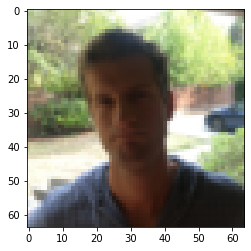

In [13]:
# Sample image from dataset
print("Image shape :",X_train_orig[10].shape)
imshow(X_train_orig[10])

In [14]:
#Model Building
# GRADED FUNCTION: HappyModel

def HappyModel(input_shape):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7,7), strides=(1,1), name='Conv2D')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2,2), name='max_pool')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    model = Model(inputs = X_input, outputs=X, name='HappyModel')
        
    return model

In [57]:
# # Model flow chart
# happyModel = HappyModel(X_train[0].shape)
# plot_model(happyModel, to_file='HappyModel.png')
# SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))

In [16]:
happyModel.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
Conv2D (Conv2D)              (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings the compare two face images as follows:

<img src="images/distance_kiank.png" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2**: <br> </u> <font color='purple'> By computing a distance between two encodings and thresholding, you can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other 
- The encodings of two images of different persons are very different

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 

<img src="images/triplet_comparison.png" style="width:280px;height:150px;">
<br>
<caption><center> <u> <font color='purple'> **Figure 3**: <br> </u> <font color='purple'> In the next part, we will call the pictures from left to right: Anchor (A), Positive (P), Negative (N)  </center></caption>

### The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.

Implement the triplet loss as defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.reduce_mean`, `tf.maximum()`.

### Predicting using various Optimizers

In [17]:
happyModel_sgd = HappyModel(X_train.shape[1:])
happyModel_sgd.compile(optimizer='sgd', loss='binary_crossentropy', metrics=["accuracy"])

In [18]:
history_sgd = happyModel_sgd.fit(X_train,Y_train, epochs=5,batch_size=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
600/600 [==============================] - 7s 11ms/step - loss: 7.4348 - acc: 0.4950
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000


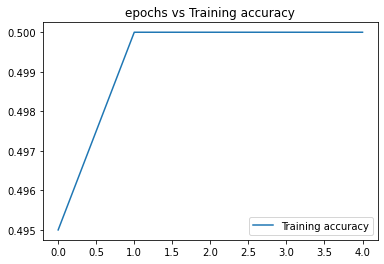

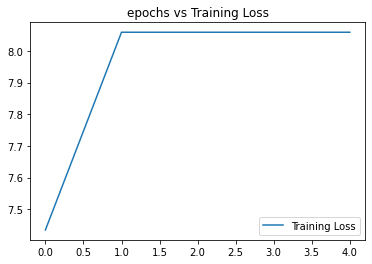

In [19]:
train_accuracy = history_sgd.history['acc']
train_loss = history_sgd.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [20]:
preds = happyModel_sgd.evaluate(x=X_test, y=Y_test)

print ("\nLoss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 9.026133677164713
Test Accuracy = 0.4400000015894572


In [21]:
#RMS Optimizer
happyModel_rms = HappyModel(X_train.shape[1:])
happyModel_rms.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=["accuracy"])

In [22]:
history_rms = happyModel_rms.fit(X_train,Y_train, epochs=5,batch_size=30)

Epoch 1/5
600/600 [==============================] - 6s 10ms/step - loss: 7.7711 - acc: 0.4933
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 8.0590 - acc: 0.5000


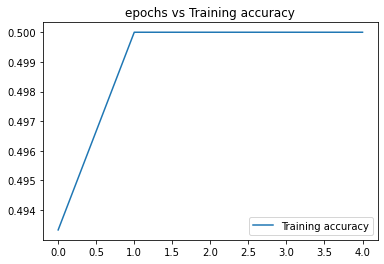

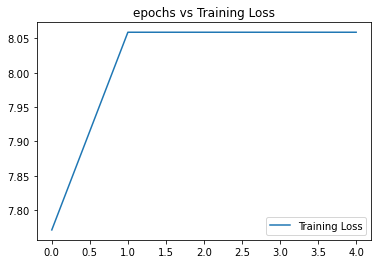

In [23]:
train_accuracy = history_rms.history['acc']
train_loss = history_rms.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [24]:
preds = happyModel_rms.evaluate(x=X_test, y=Y_test)

print ("\nLoss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 9.026133677164713
Test Accuracy = 0.4400000015894572


In [25]:
happyModel_adam = HappyModel(X_train[0].shape)
happyModel_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

In [26]:
history_adam = happyModel_adam.fit(X_train,Y_train, epochs=5,batch_size=30)

Epoch 1/5
600/600 [==============================] - 7s 11ms/step - loss: 2.6389 - acc: 0.5817
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.4496 - acc: 0.8083
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 0.1891 - acc: 0.9300
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 0.1499 - acc: 0.9533
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 0.1126 - acc: 0.9650


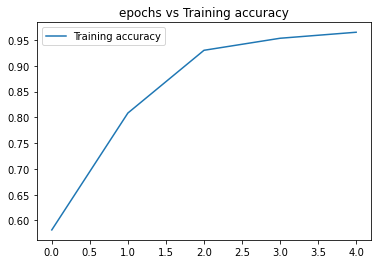

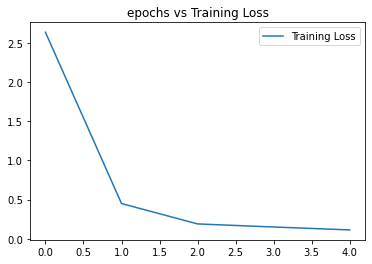

In [27]:
train_accuracy = history_adam.history['acc']
train_loss = history_adam.history['loss']

count = range(len(train_accuracy))
plt.plot(count, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(count, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [28]:
preds = happyModel_adam.evaluate(x=X_test, y=Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 0.5940619619687398
Test Accuracy = 0.7000000031789144


### Face Recognition

Implement `who_is_it()`. You will have to go through the following steps:
1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings. To loop use `for (name, db_enc) in database.items()`.
        - Compute L2 distance between the target "encoding" and the current "encoding" from the database.
        - If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

#### Predicting with different epochs trained models

In [29]:
happyModelE = HappyModel(X_train.shape[1:])
happyModelE.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

In [30]:
THistoryE = happyModelE.fit(X_train,Y_train, epochs=20,batch_size=30)

Epoch 1/20
600/600 [==============================] - 7s 12ms/step - loss: 0.8732 - acc: 0.7017
Epoch 2/20
600/600 [==============================] - 6s 10ms/step - loss: 0.3801 - acc: 0.8483
Epoch 3/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1968 - acc: 0.9383
Epoch 4/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1177 - acc: 0.9567
Epoch 5/20
600/600 [==============================] - 6s 10ms/step - loss: 0.0973 - acc: 0.9583
Epoch 6/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1067 - acc: 0.9550
Epoch 7/20
600/600 [==============================] - 6s 10ms/step - loss: 0.0800 - acc: 0.9767
Epoch 8/20
600/600 [==============================] - 6s 10ms/step - loss: 0.0709 - acc: 0.9800
Epoch 9/20
600/600 [==============================] - 6s 10ms/step - loss: 0.0574 - acc: 0.9833
Epoch 10/20
600/600 [==============================] - 6s 10ms/step - loss: 0.0611 - acc: 0.9817
Epoch 11/20
600/600 [==================

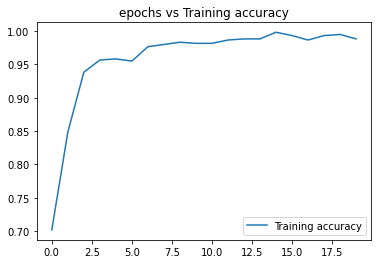

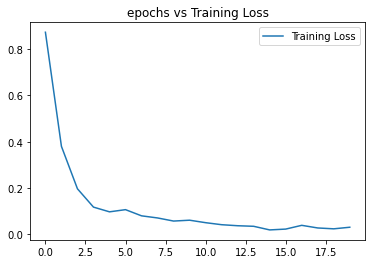

In [31]:
train_accuracy = THistoryE.history['acc']
train_loss = THistoryE.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [32]:
preds = happyModelE.evaluate(x=X_test, y=Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 0.1028983810544014
Test Accuracy = 0.94


In [33]:
y_pred = happyModelE.predict(X_test)

In [34]:
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

[[63  3]
 [ 6 78]]


In [36]:
happyModel3 = HappyModel(X_train.shape[1:])
happyModel3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

In [37]:
# THistory (Train History)
THistory3 = happyModel3.fit(X_train,Y_train, epochs=30,batch_size=30)

Epoch 1/30
600/600 [==============================] - 6s 11ms/step - loss: 2.1701 - acc: 0.6100
Epoch 2/30
600/600 [==============================] - 6s 10ms/step - loss: 0.3313 - acc: 0.8667
Epoch 3/30
600/600 [==============================] - 6s 11ms/step - loss: 0.2077 - acc: 0.9183
Epoch 4/30
600/600 [==============================] - 6s 10ms/step - loss: 0.1481 - acc: 0.9417
Epoch 5/30
600/600 [==============================] - 6s 10ms/step - loss: 0.1047 - acc: 0.9683
Epoch 6/30
600/600 [==============================] - 6s 10ms/step - loss: 0.0853 - acc: 0.9750
Epoch 7/30
600/600 [==============================] - 6s 11ms/step - loss: 0.0805 - acc: 0.9767
Epoch 8/30
600/600 [==============================] - 6s 10ms/step - loss: 0.0782 - acc: 0.9650
Epoch 9/30
600/600 [==============================] - 6s 10ms/step - loss: 0.0666 - acc: 0.9750
Epoch 10/30
600/600 [==============================] - 6s 10ms/step - loss: 0.0715 - acc: 0.9783
Epoch 11/30
600/600 [==================

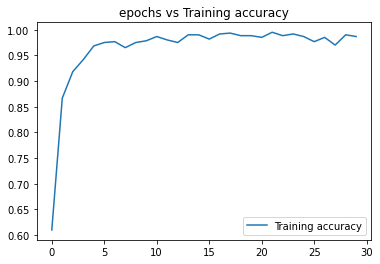

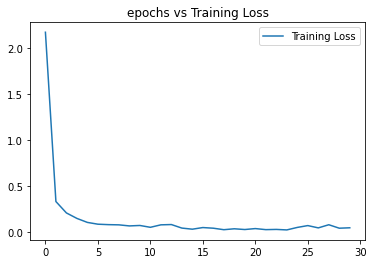

In [38]:
train_accuracy = THistory3.history['acc']
train_loss = THistory3.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [39]:
preds = happyModel3.evaluate(x=X_test, y=Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 4ms/step

Loss = 0.09540955384572347
Test Accuracy = 0.9533333309491475


In [40]:
happyModel2 = HappyModel(X_train[0].shape)
happyModel2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

In [41]:
THistory2 = happyModel2.fit(X_train,Y_train, epochs=40,batch_size=16)

Epoch 1/40
600/600 [==============================] - 7s 12ms/step - loss: 1.3407 - acc: 0.6967
Epoch 2/40
600/600 [==============================] - 6s 10ms/step - loss: 0.3615 - acc: 0.8567
Epoch 3/40
600/600 [==============================] - 6s 10ms/step - loss: 0.2094 - acc: 0.9317
Epoch 4/40
600/600 [==============================] - 6s 9ms/step - loss: 0.1040 - acc: 0.9617
Epoch 5/40
600/600 [==============================] - 6s 9ms/step - loss: 0.1233 - acc: 0.9517
Epoch 6/40
600/600 [==============================] - 6s 9ms/step - loss: 0.0840 - acc: 0.9750
Epoch 7/40
600/600 [==============================] - 6s 10ms/step - loss: 0.1383 - acc: 0.9517
Epoch 8/40
600/600 [==============================] - 6s 10ms/step - loss: 0.1432 - acc: 0.9417
Epoch 9/40
600/600 [==============================] - 6s 11ms/step - loss: 0.1443 - acc: 0.9633
Epoch 10/40
600/600 [==============================] - 6s 10ms/step - loss: 0.0776 - acc: 0.9717
Epoch 11/40
600/600 [=====================

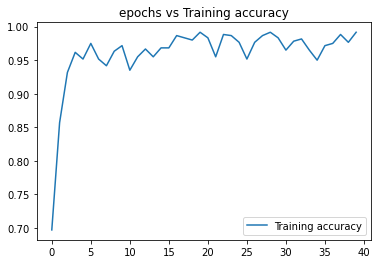

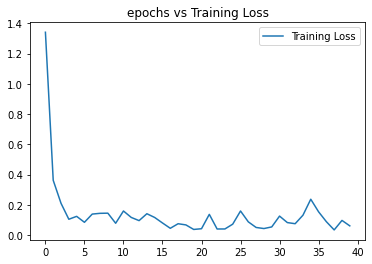

In [42]:
train_accuracy = THistory2.history['acc']
train_loss = THistory2.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [43]:
preds2 = happyModel2.evaluate(x=X_test, y=Y_test)

print()
print ("Loss = " + str(preds2[0]))
print ("Test Accuracy = " + str(preds2[1]))

150/150 [==============================] - 1s 5ms/step

Loss = 0.14446162104606627
Test Accuracy = 0.9533333309491475


#### Predicting using LeNet-5

In [44]:
# Building LeNet-5 
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(filters=1, kernel_size=(1,1), strides=(2,2), name='Conv2D', input_shape=(64,64,3))) # For converting image to 32,32,1
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=120, activation='relu'))

    model.add(layers.Dense(units=84, activation='relu'))

    model.add(layers.Dense(units=1, activation = 'sigmoid'))
    
    return model

In [45]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D (Conv2D)              (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)              

In [56]:
# plot_model(model, to_file='HappyModel.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

Epoch 1/20
600/600 [==============================] - 1s 2ms/step - loss: 0.6883 - acc: 0.5450
Epoch 2/20
600/600 [==============================] - 0s 485us/step - loss: 0.6647 - acc: 0.6483
Epoch 3/20
600/600 [==============================] - 0s 475us/step - loss: 0.5787 - acc: 0.7183
Epoch 4/20
600/600 [==============================] - 0s 480us/step - loss: 0.4997 - acc: 0.7583
Epoch 5/20
600/600 [==============================] - 0s 484us/step - loss: 0.4230 - acc: 0.7967
Epoch 6/20
600/600 [==============================] - 0s 532us/step - loss: 0.3378 - acc: 0.8783
Epoch 7/20
600/600 [==============================] - 0s 484us/step - loss: 0.2804 - acc: 0.8850
Epoch 8/20
600/600 [==============================] - 0s 475us/step - loss: 0.2359 - acc: 0.9100
Epoch 9/20
600/600 [==============================] - 0s 472us/step - loss: 0.2589 - acc: 0.8750
Epoch 10/20
600/600 [==============================] - 0s 468us/step - loss: 0.1943 - acc: 0.9350
Epoch 11/20
600/600 [==========

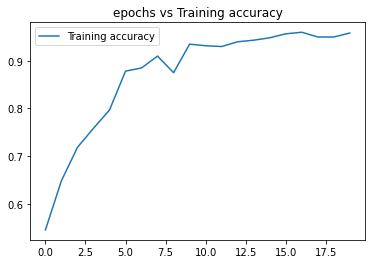

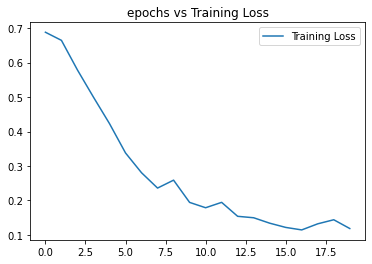

In [47]:
lenet5 = create_model()
lenet5.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])
history = lenet5.fit(X_train,Y_train, epochs=20,batch_size=32)

train_accuracy = history.history['acc']
train_loss = history.history['loss']

iterations = range(len(train_accuracy))
plt.plot(iterations, train_accuracy, label='Training accuracy')
plt.title('epochs vs Training accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, train_loss, label='Training Loss')
plt.title('epochs vs Training Loss')
plt.legend()

In [48]:
preds = lenet5.evaluate(x=X_test, y=Y_test)

print ("\nLoss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 1ms/step

Loss = 0.2293972412745158
Test Accuracy = 0.9266666706403096
